Here we are going to generate a series of synthetic liquid crystal (LC) responses using random fields. We are going to perform an analysis by computing the Euler characteristic (EC) of our sets of synthetic LC responses. 

We leverage a package called Gudhi for computing the (EC) of our images. This package create a cubical complex from the images (similar to a simplicial complex) and we can compute the EC from this complex. 

Link: https://gudhi.inria.fr/

In [1]:
#TDA Methods
import gudhi as gd

#Analysis Tools
import glob
import pickle
import numpy as np
import skimage 
from skimage import color
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter

#Create progress bar
from tqdm.notebook import trange, tqdm

#Formatting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [10, 7]

We create a function, using Gudhi, that allows us to compute the number of connected components and the number of holes of a manifold at a given filtration point. 

We then sum these values through our filtration to obtain an EC curve.

In [2]:
def getEC(data):
    cubeplex = gd.CubicalComplex(dimensions  = [np.shape(data)[1],np.shape(data)[0]],top_dimensional_cells=np.ndarray.flatten(data));
    cubeplex.persistence();
    b = np.zeros((numPoints,2)) ;
    ec = np.zeros(numPoints);
    for (i,fval) in enumerate(np.flip(filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        b[i] = [betti[0], betti[1]];
        ec[i] = betti[0] - betti[1];
    return ec;

Define EC filtration range and increments

In [3]:
numPoints = 1000;
filtrationStart = -4;
filtrationEnd = 4;
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

Create the synthetic LC sensor responses.

In [4]:
def GausField(bump,sigma):
    im = np.array(np.random.normal(0,1,(100,100))> bump).astype(float)
    gim = gaussian_filter(im,sigma = sigma)
    return gim/(np.sqrt(np.mean(gim**2)))

data2 = []
data3 = []

sigma2 = 3
sigma3 = 3

for i in range(100):
    data2.append(GausField(1,sigma2)-1) 
    
for i in range(100):
    data3.append(GausField(1.3,sigma3)-1)
    
alldata = np.vstack([data2,data3])
labels = np.arange(0,200) >= 100

Measure EC curve and compute 2D FFT for each image.

In [5]:
ec = []
fft = []
aimages = []

for i in tqdm(range(len(alldata))):
    
    aimage = alldata[i]
    ec.append(getEC(aimage))
    fft.append(np.real(np.fft.fftn(aimage)).flatten())
    aimages.append(aimage.flatten())

  0%|          | 0/200 [00:00<?, ?it/s]

Plot example images of responses to each environment.

Text(0.5, 1.0, 'Environment 1')

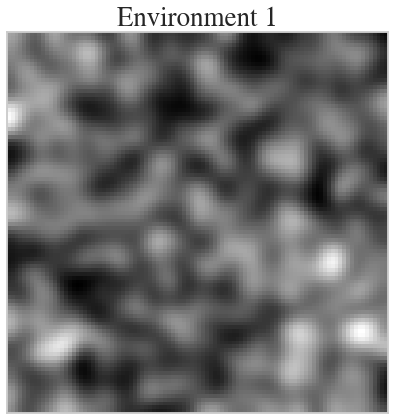

In [6]:
plt.figure()

i = 10

plt.imshow(aimages[i].reshape(100,100),cmap = 'gray')
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title("Environment 1")


Text(0.5, 1.0, 'Environment 2')

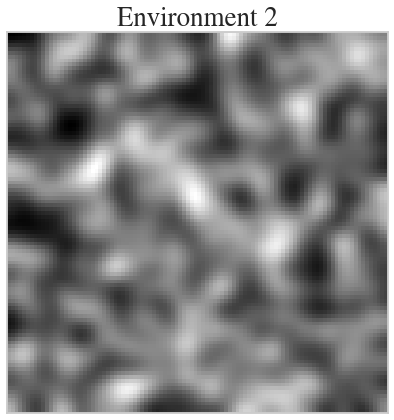

In [7]:
plt.figure()

i = -10

plt.imshow(aimages[i].reshape(100,100),cmap = 'gray')
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title("Environment 2")

Plot the average EC value for each environment.

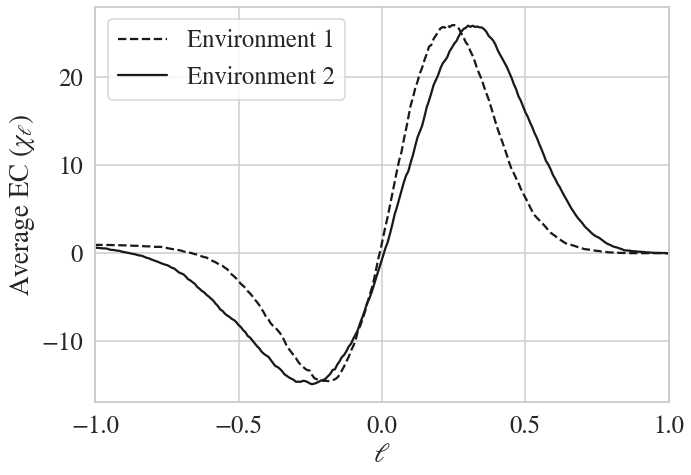

In [8]:
ecv = np.vstack(ec)

Mix1EC = np.mean(ecv[0:100],axis = 0)

Mix2EC = np.mean(ecv[100::],axis = 0)

plt.plot(filtrations,Mix1EC, '--k', label = "Environment 1")
plt.plot(filtrations,Mix2EC, 'k', label = "Environment 2")

plt.legend()

plt.xlabel("$\ell$")
plt.ylabel("Average EC ($\chi_{\ell}$)")

plt.xlim(-1,1)

plt.tight_layout()
plt.savefig("avgEC_LC.svg")

Text(0.5, 1.0, 'PCA Analysis of EC Curves')

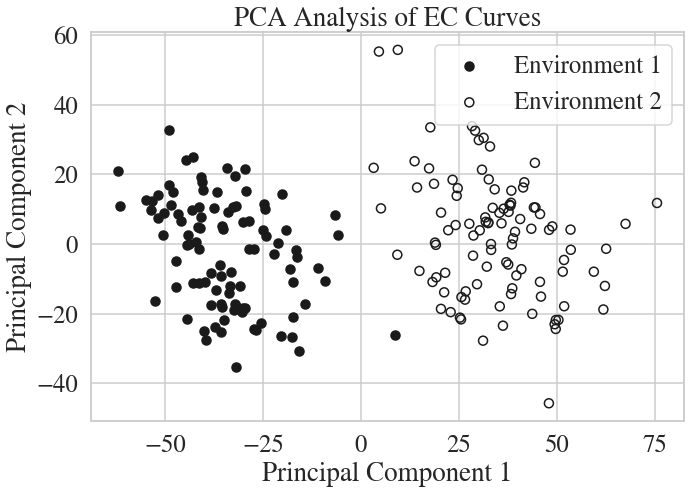

In [9]:
pca = PCA()

X = pca.fit_transform((np.vstack(ec)))

plt.figure()

plt.scatter(X[0:100,0],X[0:100,1], c = 'k', label = "Environment 1")

plt.scatter(X[100::,0],X[100::,1], label = "Environment 2", facecolor ="None", edgecolor = "k")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend()
plt.tight_layout()

plt.title("PCA Analysis of EC Curves")

Text(0.5, 1.0, 'PCA Analysis of 2D FFT')

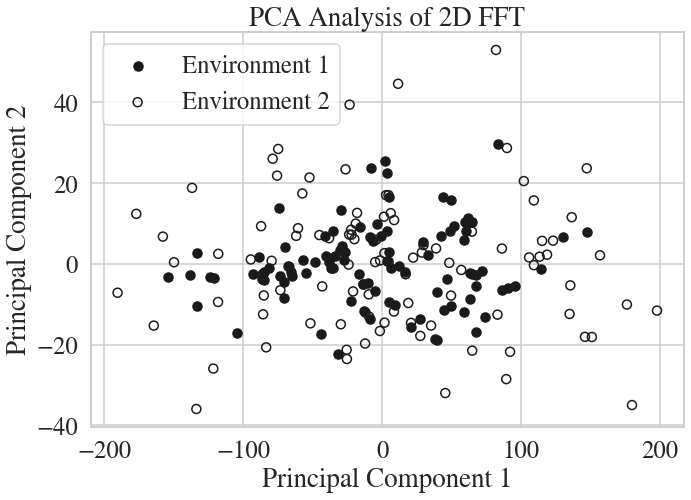

In [10]:
pca = PCA()

from scipy.stats import zscore
X = pca.fit_transform(zscore(np.vstack(fft)))

plt.scatter(X[0:100,0],X[0:100,1], c = 'k', label = "Environment 1")

plt.scatter(X[100::,0],X[100::,1], label = "Environment 2", facecolor ="None", edgecolor = "k")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend()
plt.tight_layout()

plt.title("PCA Analysis of 2D FFT")